# Custom Architecture from scratch

* The goal for this script is to build a custom model based on the YOLOv3 architecture. To accomplish it, the model will reproduce the parts of the real YOLOv3 structure:

1. **Backbone (Mini-Darknet)**: here the model will shrink down the image and extract its features.

Here's a depiction of the backbone's layers:
| Type | Filters | Size / Stride | Output Size |
| :--- | :--- | :--- | :--- |
| Input | 3 | | 416 x 416 x 3 |
| Convolutional | 32 | 3x3 / 1 | 416 x 416 x 32 |
| Convolutional | 64 | 3x3 / 2 | 208 x 208 x 64 |
| **Residual x1** | **32 / 64** | **1x1, 3x3** | **208 x 208 x 64** |
| Convolutional | 128 | 3x3 / 2 | 104 x 104 x 128 |
| **Residual x2** | **64 / 128** | **1x1, 3x3** | **104 x 104 x 128** |
| Convolutional | 256 | 3x3 / 2 | 52 x 52 x 256 |
| **Residual x2** | **128 / 256** | **1x1, 3x3** | **52 x 52 x 256** |

2. **Neck (FPN)**: this is where the information of the size of the object will be extracted. It will be done taking the feature maps from three different scales of the backbone and combine them.
3. **Heads (Prediction)**: last part of the model, the predictions (bounding boxes, objectness, class) are made from the FPN outputs, in three separate heads (as there're 3 different scales: small/medium/big).

* Representation of the full architecture:
  <div align="center">
  <img src="Mini Y Arch-1.jpg" width="800">
  <p><em>Custom Mini-YOLO Architecture Design</em></p>
</div>

---
Credits to:
* Redmon, Joseph and Ali Fahardi for [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640), [YOLOv3](https://arxiv.org/pdf/1804.02767) papers.
* [Geeksforgeeks' blog](https://arxiv.org/pdf/1804.02767) for the inspiration in implementing YOLOv3 from scratch.
* [Andrew Ng from DeepLearning.ai](https://www.deeplearning.ai/courses/deep-learning-specialization/) for the intuition and theory explanation of YOLO architecture. 


## 1. Frameworks

In [17]:
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np

INPUT_DIR = '/kaggle/input/pascal-voc-eda-and-preprocessing'

train_list_path = os.path.join(INPUT_DIR, 'train.txt')
val_list_path = os.path.join(INPUT_DIR, 'val.txt')

LABELS_DIR = os.path.join(INPUT_DIR, 'labels')

## 2. Configuration

First comes the configuration that the model expects. It's going to be composed by the **classes names, the number of classes, image size and anchor boxes**.

* `Anchor boxes` serve as a predefined 'shape' so the model doesn't try to predict a bounding box's shape from scratch. It serves as a starting point for the **size and shape**, making it easier for the model to learn the small adjustments needed to get the final, bounding box.

The original model used 9 anchor boxes, and so will be done here. Per **object size(large, medium, small)** 3 anchor boxes will be used, using the same shape as in the original model.
* **Large Objects**:
    1. (116, 90)
    2. (156, 198)
    3. (373, 326)

* **Medium Objects**:
    1. (30, 61)
    2. (62, 45)
    3. (59, 119)

* **Small Objects**:
    1. (10, 13)
    2. (16, 30)
    3. (33, 23)

In [18]:
CLASS_NAMES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

NUM_CLASSES = len(CLASS_NAMES)
IMAGE_SIZE = 416 # Size the model expects

ANCHORS = [
    [(116, 90), (156, 198), (373, 326)],
    [(30, 61), (62, 45), (59, 119)],
    [(10, 13), (16, 30), (33, 23)]
]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## 3. ConvBlock

Now come the definition of all the standard blocks that are used repeatedly allong the layers of the network, first one is `ConvBlock`.

In YOLO, the convolutional block differs from the plain `Conv2d`layer. It's followed by a **Batch Normalization** layer to stabilize training and a **LeakyReLU** activation.

* **LeakyReLU** is used in order to prevent normal ReLU to turn negative values, from neurons' output, to zero, due to weight updates, making the gradient for the neuron to also be zero (The 'Dying ReLU' problem). This is the structure that prevents that:

   f(x) = max(0.1 * x, x)

In [19]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        """
        Initializes a standard YOLO convolutional block,

        Arguments:
        in_channels - Number of input channels.
        out_channels - Number of output channels.
        **kwargs - Keyword arguments for nn.Conv2d (kernel_size, stride, padding)
        """
        super().__init__()
        # Attributes
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        """
        Forward pass: Conv -> BatchNorm -> LeakyReLU
        """
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.leakyrelu(x)

        return x

## 4. ResidualBlock

Here the `ResidualBlock`is implemented in order to prevent vanishing gradient by 'skipping the connection' and adding the block's input to its output.

* It is composed by a 1x1 conv followed by a 3x3 conv, as the original **Darknet-53** backbone.

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        """
        Initializes a standard YOLO residual block (1x1 conv -> 3x3 conv -> skip)

        Arguments:
        in_channels - number of input (and output) channels
        """
        super().__init__()
        
        # Calculate the 'middle' channel dims (structure : 64 -> 32 ->64)
        mid_channels = in_channels // 2 # integer div

        # 1st conv block (1x1 kernel) to 'squeeze' channels
        self.conv1 = ConvBlock(
            in_channels,
            mid_channels,
            kernel_size = 1,
            stride = 1,
            padding = 0
        )

        # 2nd conv block (3x3 kernel) to 'expand' back
        self.conv2 = ConvBlock(
            mid_channels,
            in_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )

    def forward(self, x):
        """
        Saves the 'residual input', passes it trough the 
        two conv blocks, adds the saved residual input back 
        to the outup.
        """
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual

        return x

## 5. PredictionHead

`PredictionHead` takes the final feature map from a 'Neck' path (either small, medium, or large objects), and transform it into the final prediction tensor.
* It is composed by a `ConvBlock` to process the combined features and a final 1x1 nn.Conv2d layer (this differs from the original YOLOv3, that uses a more complex structure before the final prediction).
* The **final prediction** is a tensor that for each of the 3 different anchors includes:
  * 4 values for the bounding box (x, y, width, height).
  * 1 value for the 'objectness' score (if the object exists or not)
  * Each probability for the object to belong to that class (20 probabilities in total)

In [21]:
class PredictionHead(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors=3):
        """
        Arguments:
        in_channels - Number of input channels from the neck
        num_classes - Number of classes (20)
        num_anchors - Number of anchors (3)
        """
        super().__init__()

        # 3x3 ConvBlock to process the features from the neck
        self.conv1 = ConvBlock(
            in_channels,
            in_channels * 2, 
            kernel_size = 3,
            stride = 1,
            padding = 1
        )

        # 1x1 plain nn.Conv2d to create the final prediction
        self.conv2 = nn.Conv2d(
            in_channels * 2,
            num_anchors * (5 + num_classes),
            kernel_size = 1,
            stride = 1,
            padding = 0
        )

        # Store the number of classes and anchors for the loss function
        self.num_classes = num_classes
        self.num_anchors = num_anchors

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        return x
            

## 6.MiniYOLO model

Now it's the time to bring all the blocks together to assemble the entire architecture depicted earlier: the **Backbone**, the **Neck (FPN)**, and the **Heads**.

In [22]:
class MiniYOLO(nn.Module):
    def __init__(self, in_channels=3, num_classes=NUM_CLASSES):
        super().__init__()

        # Get num_classes from the config cell
        self.num_classes = num_classes

        # Get the anchors from the config cell,
        # register them as a buffer to move them to the GPU
        self.anchors = torch.tensor(ANCHORS).float().to(DEVICE) / 416 # divide by 416 to convert from Pixels to 0-1 range

        # ------ BACKBONE ------

        # Initial 'stem'
        self.stem = ConvBlock(in_channels, 32, kernel_size= 3, stride= 1, padding= 1)

        # Stage 1
        self.down1 = ConvBlock(32, 64, kernel_size = 3, stride= 2, padding= 1) # down ~ downsample layer
        self.res1 = ResidualBlock(64) # Route 1 (small objects)

        # Stage 2
        self.down2 = ConvBlock(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.res2 = nn.Sequential(*[ResidualBlock(128) for _ in range(2)]) # Stack 2 Residual Blocks | Route 2 (medium objects)

        # Stage 3
        self.down3 = ConvBlock(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.res3 = nn.Sequential(*[ResidualBlock(256) for _ in range(2)]) # Route 3 (large objects)

        # ------ NECK (FPN) & HEADS ------

        # Path 1 (Large Objects) - Starts from Route 3 output
        self.head1_conv = ConvBlock(256, 128, kernel_size = 1)
        self.head1_pred = PredictionHead(128, num_classes)

        # Path 2 (Medium Objects) - Upsamples Path 1 and concatenates with Route 2
        self.neck2_upsample = nn.Upsample(scale_factor = 2, mode='nearest') # Doubles the size using 'nearest neighbor' interpolation
        self.head2_conv = ConvBlock(
            128 + 128, # Upsampled - 128 + Route 2 - 128
            64,
            kernel_size = 1
        )
        self.head2_pred = PredictionHead(64, num_classes)

        # Path 3 (Small Objects) - Upsamples Path 2 and concatenates with Route 1
        self.neck3_upsample = nn.Upsample(scale_factor = 2, mode='nearest')
        self.head3_conv = ConvBlock(
            64 + 64, # Upsampled - 64 + Route 1 - 64
            32,
            kernel_size = 1
        )
        self.head3_pred = PredictionHead(32, num_classes)

    def forward(self, x):
        """
        Returns list[torch.Tensor] - a list of the 3 prediction tensors from the heads.
        """
        # Store the ouputs from the routes
        route_outputs = []

        # --- Backbone ---
        x = self.stem(x)

        x = self.down1(x)
        x = self.res1(x)
        route_outputs.append(x) # Save Route 1 (208x208x64)

        x = self.down2(x)
        x = self.res2(x)
        route_outputs.append(x) # Save Route 2 (104x104x128)

        x = self.down3(x)
        x = self.res3(x)
        # The final output is used directly (no need to save it)

        # --- Neck & Heads ---

        # Path 1 (Large Objects)
        p1 = self.head1_conv(x)
        out1 = self.head1_pred(p1)

        # Path 2 (Medium Objects)
        p1_upsample = self.neck2_upsample(p1)
        p2_concat = torch.cat(               # FPN core
            [p1_upsample, route_outputs[1]], # Concat with Route 2
            dim=1 # Concatenate on the channel dimension
        )
        p2 = self.head2_conv(p2_concat)
        out2 = self.head2_pred(p2)

        # Path 3 (Small Objects)
        p2_upsample = self.neck3_upsample(p2)
        p3_concat = torch.cat(
            [p2_upsample, route_outputs[0]], # Concat with Route 1
            dim = 1
        )
        p3 = self.head3_conv(p3_concat)
        out3 = self.head3_pred(p3)

        # Return the 3 prediction outputs from smallest grid (out1) to largest (out3)
        return [out1, out2, out3]

## 7. Loss for MiniYOLO

To obtain a loss metric, a final block will be built, `MiniYOLOLoss`. It will take the model's three raw prediction output and compare to the ground-truth labels for calculating the loss. 

It will be composed by:
* `IoU Function`: to calculate the Intersection over Union.
* `MiniYOLOLoss` class: that uses the IoU Function to calculate the three parts of the total loss:
    * **Box Loss**: How far are the bounding box coordinates.
    * **Objectness Loss**: Did the model predict there's an object and in reality there isn't.
    * **Class Loss**: The correct classification of the object.


* The standard metric to calculate the **loss in Object detection** is the **mean Average Precision (mAP)**. It won't be shown in this script as implementing it would be really time consuming. For this reason **Accuracy** is used instead (it will be used in the last part of the project:`3-object-detection-with-transfer-learning.ipynb`).

* **Intersection Over Union (IoU)**: Here will be the implementation of this algorithm. It measures how much two bounding boxes overlap: from 0.0 (no overlap) to 1.0 (perfect overlap).

With it it will be determined which is the main anchor box that captures the object and also will serve to calculate the bounding box regression box (how accurate the bounding box's position is).

In [23]:
def iou(boxes_preds, boxes_targets):
    """
    Calculates the IoU for two sets of boxes.
    Format of boxes: [x1(xmin), y1(ymin), x2(xmax), y2(ymax)] (corners)

    Arguments:
    boxes_preds - Predictions tensor of shape (N, 4)
    boxes_targets - Targets tensor of shape (1, 4)

    Returns :
    IoU values for each pair in a tensor of shape (N, 1)
    """
    # x increases as you move right, y increases as you move down
    # Get coordinates for Intersection

    # Top-left corner of the intersection box
    box1_x1 = boxes_preds[..., 0:1] # Keep all the batch dims to correctly broadcast
    box1_y1 = boxes_preds[..., 1:2]
    box2_x1 = boxes_targets[..., 0:1]
    box2_y1 = boxes_targets[..., 1:2]

    # Find the inner-most x1 and y1 (where the overlap starts)
    int_x1 = torch.max(box1_x1, box2_x1)
    int_y1 = torch.max(box1_y1, box2_y1)

    # Bottom-right corner of the intersection box
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]
    box2_x2 = boxes_targets[..., 2:3]
    box2_y2 = boxes_targets[..., 3:4]

    # Find the inner-most x2 and y2
    int_x2 = torch.min(box1_x2, box2_x2)
    int_y2 = torch.min(box1_y2, box2_y2)

    # Intersection Area
    intersection_width = (int_x2 - int_x1).clamp(0) # .clamp(0) is to prevent a negative value if the boxes don't overlap
    intersection_height = (int_y2 - int_y1).clamp(0)
    intersection_area = intersection_width * intersection_height

    # Union Area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - intersection_area

    # IoU Calculation
    iou = intersection_area / (union_area + 1e-6) # prevent division by 0 if union_area = 0

    return iou

* `MiniYOLOLoss`: this will be the nn.Module class that uses the IoU function to calculate the parts described earlier.

The loss will be coded so targets are tensors where each row is a bounding box: [image_index, class_label, x, y, width, height]. The coordinates x, y, w, h will be normalized (range 0-1) relative to the image size.

In [24]:
class MiniYOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss() # Mean Squared Error for boundig box coords.
        self.bce = nn.BCEWithLogitsLoss() # Binary Cross Entropy for objectness and class
        self.sigmoid = nn.Sigmoid()

        # Constans (Lambda values) from the orginal paper to balance the loss
        self.lambda_class = 1
        self.lambda_noobj = 10 # Heavily penalize false positives (empty cells)
        self.lambda_obj = 1
        self.lambda_box = 10 # Penalize inaccurate bounding boxes

    def forward(self, predictions, target, anchors):
        """
        Arguments:
        predictions - List of 3 tensors from the model [out1, out2, out3]
        target - Tensor of shape (N, 6) -> [img_idx, class, x, y, w, h]
        anchors - list of 9 anchors from configuration
        """
        # Identify which device is the model working on (GPU/CPU)
        device = predictions[0].device
        loss = 0

        # Loop trough each of the 3 object scales
        for i in range(3):
            # Get the predictions of the current scale
            out = predictions[i]

            # Get the 3 anchors appropiate for this scale
            # (anchors is a list of lists with 3 sizes per entry)
            anchors_this_scale = anchors[i]

            # Get batch and grid size (52, 104, 208)
            batch_size, _, grid_size, _ = out.shape

            # Build the Target Tensor
            # Helper method to get the masks for where the objects are, where the background is and the math targets
            targets_tuple = self.build_targets(
                predictions[i], target, anchors_this_scale, grid_size, device
            )

            obj_mask, noobj_mask, t_box, t_cls, t_conf, pred_box, pred_cls, pred_conf = targets_tuple

            # Calculate Losses

            # 1. No Object Loss
            loss_noobj = self.bce(pred_conf[noobj_mask], t_conf[noobj_mask])

            # 2. Object Loss
            if obj_mask.sum() > 0:   # Check if there are objects in this scale
                
                loss_obj = self.bce(pred_conf[obj_mask], t_conf[obj_mask])

                # 3. Box Coordinate Loss
                loss_box = self.mse(pred_box[obj_mask], t_box[obj_mask])

                # 4. Class Loss
                loss_class = self.bce(pred_cls[obj_mask], t_cls[obj_mask])

                # Combine
                loss += (
                    (self.lambda_box * loss_box)
                    + (self.lambda_obj * loss_obj)
                    + (self.lambda_noobj * loss_noobj)
                    + (self.lambda_class * loss_class)
                )
            else:
                loss += (self.lambda_noobj * loss_noobj) # If no objects, only penalize false positives
        
        return loss

    def build_targets (self, pred_tensor, target, anchors, grid_size, device):
        """
        Helper function that matches the Ground Truth boxes (labels) to the specific Grid Cell 
        and Anchor that should predict them.

        Arguments:
        pred_tensor - prediction tensor for one of the three size ranges [Batch, Channels, Height, Width]
        grid size - integer of the grid's size for the size range (52, 104, 208)
        device - type of device the model is running on (GPU/CPU)
        """

        batch_size = pred_tensor.shape[0]
        num_anchors = len(anchors)
        num_classes = pred_tensor.shape[1] // num_anchors - 5 # The number of channels is 75: 3 anchors x 25 atributes per anchor (x,y,w,h,conf + 20 classes)

        # Move anchors to GPU to prevent crashes
        if isinstance(anchors, list):
            anchors = torch.tensor(anchors).to(device)
        else: anchors = anchors.to(device)

        # Create Target Tensors
        obj_mask = torch.zeros((batch_size, num_anchors, grid_size, grid_size), dtype=torch.bool).to(device) # Starts as all False(0) - Will mark True only where object exists
        noobj_mask = torch.ones((batch_size, num_anchors, grid_size, grid_size), dtype=torch.bool).to(device) # Assumes everything is background (1) until an object is found

        t_box = torch.zeros((batch_size, num_anchors, grid_size, grid_size, 4)).to(device) # Holds the correct (x, y, w, h) for specific cells
        t_cls = torch.zeros((batch_size, num_anchors, grid_size, grid_size, num_classes)).to(device) # Holds the correct class probs. (One-hot encoded)
        t_conf = torch.zeros((batch_size, num_anchors, grid_size, grid_size)).to(device) # Holds 'Objectness' score (1 - object, 0 - background)

        # Reshape predictions so it's easier to access to specific attributes
        pred_tensor = pred_tensor.view(batch_size, num_anchors, 5 + num_classes, grid_size, grid_size) # split the 75 channels into 3 anchors separate groups
        pred_tensor = pred_tensor.permute(0, 1, 3, 4, 2) # Move the final 25 attributes to the end - Final output: [Batch, 3, Grid_size, Grid_size, 25]

        # Extraction of x, y, w, h
        pred_box_x = self.sigmoid(pred_tensor[..., 0]) # Sigmoid to force x and y predictions to stay inside their specific grid cell
        pred_box_y = self.sigmoid(pred_tensor[..., 1])
        pred_box_w = pred_tensor[..., 2]
        pred_box_h = pred_tensor[..., 3]
        pred_conf = pred_tensor[..., 4]
        pred_cls = pred_tensor[..., 5:]
        
        pred_box = torch.cat((pred_box_x.unsqueeze(-1), pred_box_y.unsqueeze(-1), pred_box_w.unsqueeze(-1), pred_box_h.unsqueeze(-1)), dim=-1)


        # Match Targets
        for idx in range(target.shape[0]):
            img_idx, class_label, gx, gy, gw, gh = target[idx] # gx-gh are normalized (0.0-1.0)
            img_idx =  int(img_idx)
            
            # Map the coordinates to grid cells
            grid_x = int(gx * grid_size) # Example: grid size = 13, gx = 0.5, int(0.5 * 13) = 6 ~ object belongs to cell 6
            grid_y = int(gy * grid_size)

            # Prevent crash as the grid size cells are 0-indexed (if grid size = 13 - cells go 0:12)
            if grid_x >= grid_size: grid_x = grid_size - 1
            if grid_y >= grid_size: grid_y = grid_size - 1

            # ----- IoU Check ----- 
            gt_box_shape = torch.tensor([0, 0, gw, gh]).unsqueeze(0).to(device) # Create a generic tensor that represent the Ground Truth object's dims.

            # Create anchor shapes tensor on device
            anchors_corners = torch.cat([torch.zeros((num_anchors, 2)).to(device), anchors], dim=1) # stack the anchors size by size [[0,0,w1,h1],[0,0,w2,h2],[0,0,w3,h3]]

            # Convert anchors [0,0,w,h] to top-left/bottom-right corners coordinates [x1, y1, x2, y3] centered at 0
            anchors_corners_xy = torch.zeros_like(anchors_corners) # Empty container of shape (3, 4)
            anchors_corners_xy[:, 0] = -anchors_corners[:, 2] / 2 # x1 = 0 - width/2
            anchors_corners_xy[:, 1] = -anchors_corners[:, 3] / 2 # y1 = 0 - height(2)
            anchors_corners_xy[:, 2] = anchors_corners[:, 2] / 2  # x2 = 0 + width/2
            anchors_corners_xy[:, 3] = anchors_corners[:, 3] / 2  # y2 = 0 + height/2

            # Same operation for Ground Truth box coordinates
            gt_box_corners = torch.zeros_like(gt_box_shape)
            gt_box_corners[:, 0] = -gt_box_shape[:, 2] / 2
            gt_box_corners[:, 1] = -gt_box_shape[:, 3] / 2
            gt_box_corners[:, 2] = gt_box_shape[:, 2] / 2
            gt_box_corners[:, 3] = gt_box_shape[:, 3] / 2

            # Calculate IoU between the GT box and the 3 anchors
            ious = iou(gt_box_corners, anchors_corners_xy)

            # Extract the best IoU
            best_anchor_idx = torch.argmax(ious)

            # ----- Assign the results  -----
            # Objectness
            obj_mask[img_idx, best_anchor_idx, grid_y, grid_x] = 1 # Mark the slot as 'Has Object'
            noobj_mask[img_idx, best_anchor_idx, grid_y, grid_x] = 0 # 'No object mask' ignores the slot

            # Coordinates
            # 1. Offset relative to the grid cell top-left
            t_x_cell = gx * grid_size - grid_x
            t_y_cell = gy * grid_size - grid_y

            # 2. Width/Height relative to the anchor (Log Space)
            w_anchor = anchors[best_anchor_idx][0]
            h_anchor = anchors[best_anchor_idx][1]
            t_w_cell = torch.log((gw / w_anchor) + 1e-6)
            t_h_cell = torch.log((gh / h_anchor) + 1e-6)

            # 3. Save these targets into the t_box tensor
            t_box[img_idx, best_anchor_idx, grid_y, grid_x] = torch.tensor(
                [t_x_cell, t_y_cell, t_w_cell, t_h_cell]
            ).to(device)

            # ----- Class -----
            # Set the correct class index to 1 (One-hot Enc.)
            t_cls[img_idx, best_anchor_idx, grid_y, grid_x, int(class_label)] = 1

            # Confidence - set the target objectness score
            t_conf[img_idx, best_anchor_idx, grid_y, grid_x] = 1

        return obj_mask, noobj_mask, t_box, t_cls, t_conf, pred_box, pred_cls, pred_conf

## 8. Test Check

Before building the training pipeline, lets run a little test to debug and check everything works as intended. For that a little function is implemented: `test_model_shapes()`. 

It loads the model and loss, generates a 'random pixel' dataset of 2 images and fake targets. If everything runs and the predictions outputs' shape match the expected ones means the model works.

In [25]:
def test_model_shapes():
    # 1. Create Model and Loss
    model = MiniYOLO(num_classes=NUM_CLASSES)
    loss_fn = MiniYOLOLoss()
    
    # 2. Create Fake Inputs
    # Batch of 2 images, 3 channels, 416x416
    x = torch.randn((2, 3, 416, 416))
    
    # Fake Targets: [Img_ID, Class, x, y, w, h]
    # 2 boxes: 
    # - Image 0, Class 1, Center(0.5, 0.5), Size(0.2, 0.2)
    # - Image 1, Class 5, Center(0.1, 0.1), Size(0.1, 0.1)
    targets = torch.tensor([
        [0, 1, 0.5, 0.5, 0.2, 0.2],
        [1, 5, 0.1, 0.1, 0.1, 0.1]
    ])
    
    # 3. Run Forward Pass
    predictions = model(x)
    
    # Check the shapes of the 3 outputs
    # Expected: [Batch, 75, Grid, Grid]
    # 75 = 3 anchors * (5 + 20 classes)
    print(f"Output 1 shape: {predictions[0].shape} (Expected: 2, 75, 52, 52)")
    print(f"Output 2 shape: {predictions[1].shape} (Expected: 2, 75, 104, 104)")
    print(f"Output 3 shape: {predictions[2].shape} (Expected: 2, 75, 208, 208)")
    
    # 4. Run Loss Calculation
    # model.anchors -> because they are registered buffers in the model
    loss = loss_fn(predictions, targets, model.anchors)
    
    print(f"Loss value: {loss.item()}")
    print("\n Model and Loss are working correctly.")

# Run the test
test_model_shapes()

Output 1 shape: torch.Size([2, 75, 52, 52]) (Expected: 2, 75, 52, 52)
Output 2 shape: torch.Size([2, 75, 104, 104]) (Expected: 2, 75, 104, 104)
Output 3 shape: torch.Size([2, 75, 208, 208]) (Expected: 2, 75, 208, 208)
Loss value: 45.42378616333008

 Model and Loss are working correctly.


## 9. Data Pipeline

Now comes the last part for the **MiniYOLO** model, deploy a **Data Pipeline** to load and batch the images and finally, train and test the model.

The Data Pipeline is composed of:

* `Dataset Class`: to load the images and labels, resize them to 416x416 and convert them to Tensors.
* `DataLoader`: to batch the images and shuffle them.

* **Dataset Class**: takes the path to the set that will be used and the size to resize images to resize and conver them to tensors.

In [26]:
class YOLODataset(Dataset):
    def __init__(self, list_path, img_size=416, is_train=True, label_dir=''):
        """
        Arguments:
        list_path - Path to the train.txt or val.txt file
        img_size - size to resize images to
        is_train - Wheter this is training data or not
        label_dir - Path to the folder where the labels are stored
        """
        self.img_size = img_size
        self.is_train = is_train
        self.label_dir = label_dir  # Store the passed directory

        # Load the list of image paths
        with open(list_path, 'r') as f:
            self.img_paths = f.read().splitlines()

        # Define basic transforms
        # If it's training data, add noise/color changes
        if is_train:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                # Randomly change brightness, constrast and saturation
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
                transforms.ToTensor(),
            ])
        else:
            # For validation, just resize
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index): # Index is handled by DataLoader 
        # --- Get Image ---
        img_path = self.img_paths[index]

        # Open image and convert to RGB
        image = Image.open(img_path).convert('RGB')

        # Apply resizing and tensor conversion
        # Labels are normalized - resizing doesn't require to change label's coordinates
        image = self.transform(image)

        # --- Get Label ---
        # Construct label path
        basename = os.path.splitext(os.path.basename(img_path))[0]
        
        # Build full path
        label_path = os.path.join(self.label_dir, basename + '.txt')

        # Load boxes
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    # Line format: class x y w h
                    class_label, x, y, w, h = map(float, line.strip().split())
                    boxes.append([class_label, x, y, w, h])

        # Convert to Tensor
        if len(boxes) > 0:
            boxes = torch.tensor(boxes)
        else: 
            # Handle negative images (no boxes)
            boxes = torch.zeros((0, 5)) # Return a dummy tensor of shape (0, 5)

        # Add Image Index
        # MiniYOLOLoss() expects [Image_Index, Class, x, y, w, h]
        img_index = torch.zeros((boxes.shape[0], 1)) # Initally set to 0 - DataLoader collate_fn will fix this later
        target = torch.cat((img_index, boxes), dim=1)

        return image, target

* `yolo_collate_fn function`: this is an helper **collation** function used to stack the images, concatenate the targets (boxes) into one long list and update the **img_index** so the model knows which boxes belong to which image.

In [27]:
def yolo_collate_fn(batch):
    """
    Custom collate function to handle batches where images 
    have different number of bounding boxes.
    """
    images = []
    targets = []

    #Loop throght the batch (list of (img, target))
    for i, (img, target) in enumerate(batch):
        images.append(img)

        # Update the image index column to match the batch index 'i'
        target[:, 0] = i
        targets.append(target)

    # Stack images [Batch, 3, 416, 416]
    images = torch.stack(images, 0)

    # Concatenate targets: [Total Boxes in batch, 6]
    targets = torch.cat(targets, 0)

    return images, targets

Here is a little check to test that `YOLODataset` and `yolo_collate_fn` are working correctly:

In [28]:
def test_dataset():
    
    # 1. Define Paths
    INPUT_DIR = '/kaggle/input/pascal-voc-eda-and-preprocessing'
    
    train_list_path = os.path.join(INPUT_DIR, 'train.txt')
    label_dir_path = os.path.join(INPUT_DIR, 'labels')

    # 2. Initialize Dataset
    dataset = YOLODataset(
        train_list_path,
        label_dir=label_dir_path
    )

    print(f"Dataset loaded. Total images: {len(dataset)}")
    
    # 3. Initialize DataLoader
    dataloader = DataLoader(
        dataset, 
        batch_size=4, 
        shuffle=True, 
        collate_fn=yolo_collate_fn 
    )
    
    # 4. Get one batch
    images, targets = next(iter(dataloader))
    
    print(f"Batch Images Shape: {images.shape} (Expected: 4, 3, 416, 416)")
    print(f"Batch Targets Shape: {targets.shape}") 
    print("Targets format: [Img_ID, Class, x, y, w, h]")
    
    # Check if img_ids are correct (0, 1, 2, 3)
    print(f"Image IDs in targets: {targets[:, 0].unique()}")

test_dataset()

Dataset loaded. Total images: 2501
Batch Images Shape: torch.Size([4, 3, 416, 416]) (Expected: 4, 3, 416, 416)
Batch Targets Shape: torch.Size([6, 6])
Targets format: [Img_ID, Class, x, y, w, h]
Image IDs in targets: tensor([0., 1., 2., 3.])


* **DataLoader Set Up**: this is the last step before training the model! Here the **hyperparameters** will get definded as well as the **Train and Val DataLoaders** and the **Optimizer**.

In [29]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
WEIGHT_DECAY = 1e-3
NUM_EPOCHS = 20
NUM_WORKERS = 2 # Speeds data loading
PIN_MEMORY = True # Speeds transfer to GPU


# Initialize Datasets
train_dataset = YOLODataset(
    train_list_path,
    is_train=True,
    label_dir = LABELS_DIR
)

val_dataset = YOLODataset(
    val_list_path,
    is_train=False,
    label_dir = LABELS_DIR
)

# Initalize DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=yolo_collate_fn,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=yolo_collate_fn,
    drop_last=False
)

# Model & Optimizer

model = MiniYOLO(num_classes=NUM_CLASSES).to(DEVICE)

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Reduce LR by factor of 0.1 if validation loss doesn't improve for 3 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

loss_fn = MiniYOLOLoss()

## 10. Training Engine

After all is correctly defined, is time to train the model. For that, first `train_fn` is defined to set up the forward and backward pass for a single epoch and calculate the loss. Then, `validate_fn` is defined to do the same but without updating the weights. After that, comes the **Main loop** where the model will iterate trough all epochs, train and validate the model.

* `train_fn`:

In [41]:
def train_fn(train_loader, model, optimizer, loss_fn, epoch):
    """
    Runs one epoch of training.
    """
    model.train() # Set model to training mode (enables, Dropout, BatchNorm)
    mean_loss = []

    for batch_idx, (x,y) in enumerate(train_loader):
        # Move data to GPU
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Forward Pass
        out = model(x)

        # Loss
        loss = loss_fn(out, y, model.anchors) # model.anchors are part of the model config.

        # Backward Pass
        optimizer.zero_grad() # Clear old grads
        loss.backward()       # Calculate new grads
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0) # Gradient clipping to prevent exploding
        optimizer.step()      # Update weigths

        # Track Loss
        mean_loss.append(loss.item())

        # Print status every 50 batches to keep track
        if batch_idx % 50 == 0:
             print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_loss = sum(mean_loss) / len(mean_loss)
    print(f"Training Loss: {avg_loss}")

    return avg_loss




* `validate_fn`: 

In [39]:
def validate_fn(val_loader, model, loss_fn):
    """
    Runs the model on the validation set to calculate loss without updating weights.
    """
    model.eval() # Set to evaluation mode (freezes BatchNorm, disables Dropout)
    mean_loss = []

    # torch.no_grad() because there isn't need of gradients for validation
    # This saves massive amounts of memory and computation
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            # Forward Pass
            out = model(x)

            # Calculate Loss
            loss = loss_fn(out, y, model.anchors)
            mean_loss.append(loss.item())


    avg_loss = sum(mean_loss) / len(mean_loss)
    print(f"Validation Loss: {avg_loss}")
    
    return avg_loss

* **Main training loop**:     

In [42]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS}")

    # Training for this epoch
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch+1)
    train_losses.append(train_loss)
    
    # Validation for this epoch
    val_loss = validate_fn(val_loader, model, loss_fn)
    val_losses.append(val_loss)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    # Save Best Model 
    if val_loss < best_val_loss:
        print(f"Validation Loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving 'mini_yolo_best.pth'")
        best_val_loss = val_loss
        torch.save(model.state_dict(), "mini_yolo_best.pth")
    
    # Regular checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"mini_yolo_epoch_{epoch+1}.pth")

print("\n Training Complete!")



--- Epoch 1/20
Epoch 1 | Batch 0/156 | Loss: 10.3199
Epoch 1 | Batch 50/156 | Loss: 10.8723
Epoch 1 | Batch 100/156 | Loss: 10.8480
Epoch 1 | Batch 150/156 | Loss: 11.6363
Training Loss: 10.603126733731001
Validation Loss: 13.98276981426652
Validation Loss improved (inf -> 13.9828). Saving 'mini_yolo_best.pth'

--- Epoch 2/20
Epoch 2 | Batch 0/156 | Loss: 11.6703
Epoch 2 | Batch 50/156 | Loss: 9.7672
Epoch 2 | Batch 100/156 | Loss: 10.1197
Epoch 2 | Batch 150/156 | Loss: 10.7229
Training Loss: 10.161808686378675
Validation Loss: 13.979425278438883
Validation Loss improved (13.9828 -> 13.9794). Saving 'mini_yolo_best.pth'

--- Epoch 3/20
Epoch 3 | Batch 0/156 | Loss: 9.7323
Epoch 3 | Batch 50/156 | Loss: 8.9379
Epoch 3 | Batch 100/156 | Loss: 9.4217
Epoch 3 | Batch 150/156 | Loss: 8.7337
Training Loss: 9.32663073295202
Validation Loss: 13.92316680956798
Validation Loss improved (13.9794 -> 13.9232). Saving 'mini_yolo_best.pth'

--- Epoch 4/20
Epoch 4 | Batch 0/156 | Loss: 8.9004
Epoch 

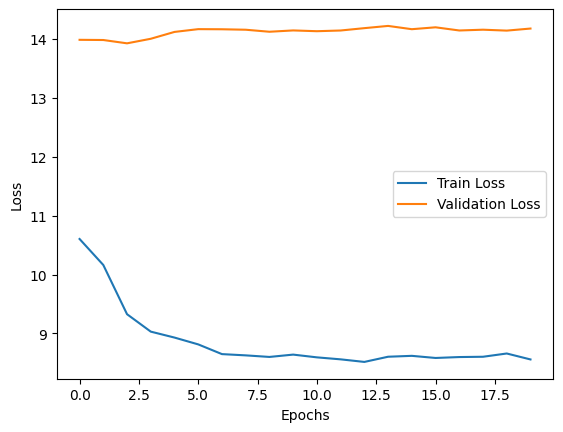

In [43]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model clearly overfits as validation remains almost constant over epochs, and the loss for training plateaus in the mid to final stages of the loop.

## 11. Post-Processing

The model is technically trained, but the data is in a raw state. To turn this into a clean detection of the bounding boxes, **Post-Processing** is implemented to also add up a visual validation to the model implemented.

This will be done by including two functions to handle this:

* `cells_to_bboxes`: that converts the prediction's output format of 'Grid cell + Offset' back into standard pixel coordinates relative to the image.
* `non_max_supression`: implementation of the **Non Max Supression** that takes all the boxes generated per object, removes the ones with low confidence and deletes duplicates that overlap significantly (with help of IoU).

In [44]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the raw predictions from the model grid (S x S) back to 
    normalized image coordinates (0 to 1).
    
    Argurments:
        predictions - tensor of Shape [Batch, 3, S, S, 25] (if reshaped) or [Batch, 75, S, S]
        anchors - list of 3 anchor tuples for this scale.
        S - Grid size (e.g., 13, 26, 52).
        is_preds - Whether input is raw predictions (needs sigmoid) or already processed.
        
    Returns:
        tensor - A tensor of shape [Batch, Num_Anchors * S * S, 6] containing 
                [class_prediction, confidence_score, x, y, w, h] relative to the image.
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    
    # Order: [x, y, w, h, conf, class]
    # x, y, w, h are indices 0, 1, 2, 3
    box_predictions = predictions[..., 0:4] 
    
    # Confidence is index 4
    scores_raw = predictions[..., 4:5]
    
    # Class is index 5 onwards
    class_raw = predictions[..., 5:]
    
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        
        # Sigmoid for x, y
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        
        # Exponent for w, h
        box_predictions[..., 2:4] = torch.exp(box_predictions[..., 2:4]) * anchors
        
        # Sigmoid for scores
        scores = torch.sigmoid(scores_raw)
        
        # Best class
        best_class = torch.argmax(class_raw, dim=-1).unsqueeze(-1)
    
    # --- GRID OFFSET ---
    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    
    # x = (offset + grid_index) / grid_size
    x = (box_predictions[..., 0:1] + cell_indices) / S
    # y = (offset + grid_index) / grid_size
    y = (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4)) / S
    
    # w, h
    w_h = box_predictions[..., 2:4]
    
    # Concatenate: [class, score, x, y, w, h]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    
    return converted_bboxes

In [45]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint", class_agnostic=True):
    """
    Performs Non-Max Suppression (NMS) on a list of bounding boxes.
    
    Arguments:
        bboxes - list of boxes [class, score, x, y, w, h]
        iou_threshold - confidence threshold for IoU
        threshold - confidence threshold to discard weak predictions.
        box_format - "midpoint" or "corners".
        class_agnostic  - If True, two overlapping boxes of DIFFERENT classes will still remove one.
                          This helps prevent "Person" and "Chair" predicting on the exact same spot.
    """
    if isinstance(bboxes, list):
        bboxes = torch.tensor(bboxes).to(DEVICE)
        
    # Filter by confidence
    mask = bboxes[:, 1] > threshold
    bboxes = bboxes[mask]
    
    if bboxes.shape[0] == 0:
        return []
    
    # Sort desc
    scores = bboxes[:, 1]
    sorted_indices = torch.argsort(scores, descending=True)
    bboxes = bboxes[sorted_indices]
    
    bboxes_after_nms = []
    
    while bboxes.shape[0] > 0:
        # Pick the "best" box
        chosen_box = bboxes[0].unsqueeze(0)
        
        # Convert to list and grab the inner list [class, score, x, y, w, h]
        flat_box = chosen_box.tolist()[0]
        bboxes_after_nms.append(flat_box)
        
        if bboxes.shape[0] == 1:
            break
            
        bboxes = bboxes[1:]
        
        # Calculate IoU
        chosen_box_coords = chosen_box[:, 2:]
        remaining_boxes_coords = bboxes[:, 2:]
        
        chosen_corners = torch.zeros_like(chosen_box_coords)
        chosen_corners[:, 0] = chosen_box_coords[:, 0] - chosen_box_coords[:, 2] / 2
        chosen_corners[:, 1] = chosen_box_coords[:, 1] - chosen_box_coords[:, 3] / 2
        chosen_corners[:, 2] = chosen_box_coords[:, 0] + chosen_box_coords[:, 2] / 2
        chosen_corners[:, 3] = chosen_box_coords[:, 1] + chosen_box_coords[:, 3] / 2
        
        remaining_corners = torch.zeros_like(remaining_boxes_coords)
        remaining_corners[:, 0] = remaining_boxes_coords[:, 0] - remaining_boxes_coords[:, 2] / 2
        remaining_corners[:, 1] = remaining_boxes_coords[:, 1] - remaining_boxes_coords[:, 3] / 2
        remaining_corners[:, 2] = remaining_boxes_coords[:, 0] + remaining_boxes_coords[:, 2] / 2
        remaining_corners[:, 3] = remaining_boxes_coords[:, 1] + remaining_boxes_coords[:, 3] / 2
        
        ious = iou(chosen_corners, remaining_corners).squeeze()
        
        # Filtering
        condition_iou = ious < iou_threshold
        
        if class_agnostic:
            mask = condition_iou
        else:
            condition_class = bboxes[:, 0] != chosen_box[0, 0]
            mask = condition_iou | condition_class
        
        bboxes = bboxes[mask]

    return bboxes_after_nms

* Helper function to handle the drawing of boxes on the images:

In [46]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = CLASS_NAMES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    
    # Convert Tensor to Numpy
    im = np.array(image)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(im)

    for box in boxes:
        class_pred = int(box[0])
        conf = box[1]
        box = box[2:]
        
        # Convert Center-Width to Top-Left Corner for plotting
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        
        rect = matplotlib.patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[class_pred],
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=f"{class_labels[class_pred]}: {conf:.2f}",
            color="white",
            verticalalignment="top",
            bbox={"color": colors[class_pred], "pad": 0},
        )

    plt.show()

* Now the last function to bring together the visual **Post-processing** check is `visualize_results`. It will take a batch from the validation set, run the trained model, apply Non-Max Supression and show a random image with the result. 

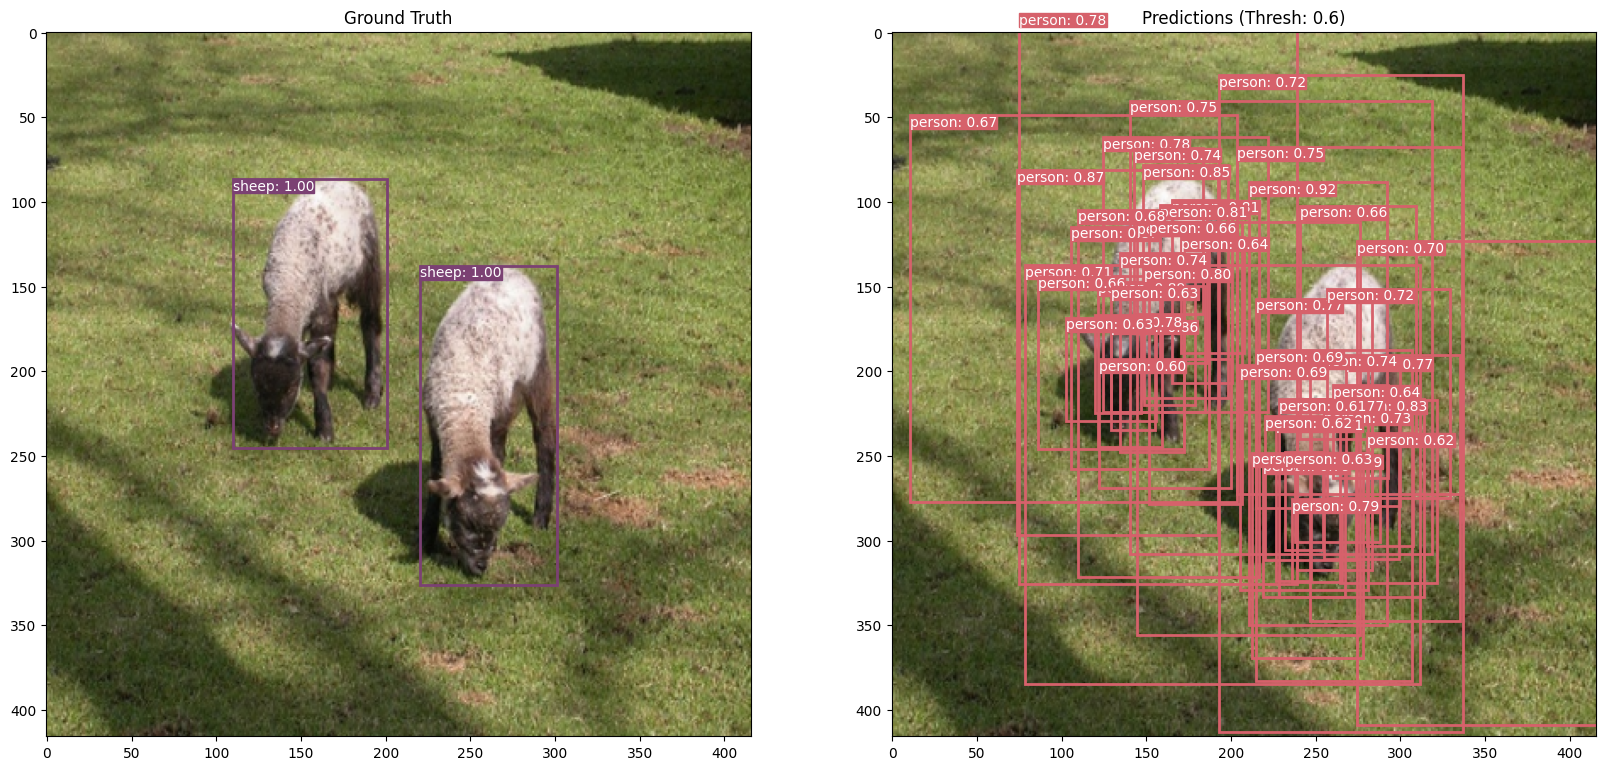

In [53]:
# Auxiliar function 
def draw_boxes_on_axis(ax, boxes, img_shape):
    """
    Draws bounding boxes and labels on a specific Matplotlib axis.
    
    Arguments:
        ax - The Matplotlib axis object to draw on.
        boxes - List of boxes, where each box is [class_id, score, x, y, w, h].
        img_shape - Tuple of (height, width, channels) to scale normalized coords.
    """
    height, width, _ = img_shape
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, len(CLASS_NAMES))]
    
    for box in boxes:
        # If 'box' is a list inside a list (e.g. [[0, 0.9...]]), flatten it.
        if isinstance(box[0], list):
            box = box[0]
            
        class_pred = int(box[0])
        conf = box[1]
        box = box[2:]
        
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        
        rect = matplotlib.patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width, box[3] * height,
            linewidth=2, edgecolor=colors[class_pred], facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            upper_left_x * width, upper_left_y * height,
            s=f"{CLASS_NAMES[class_pred]}: {conf:.2f}",
            color="white", verticalalignment="top",
            bbox={"color": colors[class_pred], "pad": 0},
        )

def visualize_results(model, loader=None, image=None, threshold=0.5, iou_threshold=0.5):
    """
    Runs inference on an image (or batch) and visualizes the result with Non-Max Sup. applied.
    """
    model.eval()
    
    if image is not None:
        x = image.to(DEVICE).unsqueeze(0)
        y = None 
    elif loader is not None:
        x, y = next(iter(loader))
        x = x.to(DEVICE)
        y = y.to(DEVICE)
    else:
        print("Error: Provide 'loader' or 'image'")
        return

    with torch.no_grad():
        out = model(x)
        all_bboxes_list = []
        for i in range(3):
            batch_size, _, S, _ = out[i].shape
            predictions = out[i].view(batch_size, 3, 25, S, S).permute(0, 1, 3, 4, 2)
            anchor = model.anchors[i]
            boxes_scale = cells_to_bboxes(predictions, anchor, S=S, is_preds=True)
            all_bboxes_list.append(boxes_scale)
        all_bboxes = torch.cat(all_bboxes_list, dim=1)

    nms_boxes = non_max_suppression(
        all_bboxes[0], 
        iou_threshold=iou_threshold, 
        threshold=threshold,
        box_format="midpoint",
        class_agnostic=True
    )
    
    gt_boxes = []
    if y is not None:
        first_img_targets = y[y[:, 0] == 0]
        for target in first_img_targets:
            box = [int(target[1]), 1.0] + target[2:].tolist()
            gt_boxes.append(box)

    plot_img = x[0].permute(1, 2, 0).to("cpu")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Ground Truth
    if gt_boxes:
        axes[0].imshow(np.array(plot_img))
        axes[0].set_title("Ground Truth")
        draw_boxes_on_axis(axes[0], gt_boxes, np.array(plot_img).shape)
    else:
        axes[0].imshow(np.array(plot_img))
        axes[0].set_title("Ground Truth (No Objects)")
        
    # Predictions
    axes[1].imshow(np.array(plot_img))
    axes[1].set_title(f"Predictions (Thresh: {threshold})")
    draw_boxes_on_axis(axes[1], nms_boxes, np.array(plot_img).shape)
    
    plt.show()

# Create a temporary loader with shuffle=True
# batch_size=1 to just grab one random image at a time
vis_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=True, 
    collate_fn=yolo_collate_fn
)

visualize_results(model, loader=vis_loader, threshold=0.6, iou_threshold=0.5)

## Conclussions



As seen from the final performance after training and the comparison of the **Ground Truth Image** vs how the model does, the outcome is far from what should be a fully functional **Object Detection Neural Network**. It learns how to localize objects but struggles with **classification**. This is due to 3 major factors:

* The architecture was adapted for a reasonable complexity diverging from the deeper one used in the original paper.
* The dataset is limited to 5011 images, and training was done with half of it. A fully functional object detection network normally is trained on vast images datasets much bigger than the one in hand.
* From the **EDA** can be inferred that **PASCAL VOC Dataset** is heavily skewed towards the **Person Class** (there're almost 5000 objects classified as persons compared to the second most populated, cars with ~ 1500). This makes a class imbalance that can be appreciated in the **Post-processing** representation of images.

As the loss plateus for the final epochs, the maximum value of this architecture is extracted. In order to improve some fine-tuning could be done, but instead of that, lets head to the final script of this project in order to obtain a fully functional one that achieves the desired performance, in this case with transfer learning.